#  Food Demand Forecasting Project



##  Problem Statement

In this project, we aim to forecast food demand for a meal delivery service. The dataset is provided as part of a real-world challenge hosted on **Analytics Vidhya**. The business objective is to accurately predict the number of orders for various meals across different fulfillment centers and weeks, helping the company optimize inventory, reduce waste, and prevent stockouts.

Meal delivery services work with highly perishable raw materials, so accurate demand prediction is critical. Overstocking leads to waste and financial loss, while understocking leads to missed sales opportunities and poor customer experience.



##  Dataset Overview

The dataset consists of three main files:

- `train.csv` – Historical data for training the model  
- `test.csv` – Data for which we need to generate predictions  
- `meal_info.csv` – Metadata about each meal  
- `fulfilment_center_info.csv` – Metadata about each delivery center  



##  Column Descriptions

### `train.csv` & `test.csv`

| Column Name         | Description                                                                 |
|---------------------|-----------------------------------------------------------------------------|
| `id`                | Unique ID for each row                                                      |
| `week`              | Week number of the year                                                     |
| `center_id`         | Unique ID of the fulfillment center                                         |
| `meal_id`           | Unique ID of the meal                                                       |
| `checkout_price`    | Final price paid by the customer (after discounts, if any)                 |
| `base_price`        | Base price of the meal before any discount                                  |
| `emailer_for_promotion` | Whether the meal was promoted via email (0 = No, 1 = Yes)                |
| `homepage_featured` | Whether the meal was promoted on the homepage (0 = No, 1 = Yes)             |
| `num_orders`        | (Target) Number of meal orders placed                                       |

> Note: In the test set, `num_orders` is missing because that’s what we aim to predict.

---

### `meal_info.csv`

| Column Name | Description                        |
|-------------|------------------------------------|
| `meal_id`   | Unique ID of the meal              |
| `category`  | Type of meal (e.g., Soup, Beverage)|
| `cuisine`   | Cuisine of the meal (e.g., Indian, Italian) |

---

### `fulfilment_center_info.csv`

| Column Name      | Description                          |
|------------------|--------------------------------------|
| `center_id`      | Unique ID of the fulfillment center  |
| `city_code`      | Categorical location code of the city|
| `region_code`    | Categorical location code of the region |
| `center_type`    | Type of center (A/B/C etc.)          |
| `op_area`        | Operational area size in square km   |



##  Goal

To build a regression model that can predict the `num_orders` for each `(meal_id, center_id, week)` combination using the features provided. Evaluation is typically done using metrics like **Root Mean Squared Error (RMSE)** .



## 🛠 Project Workflow

1. Load and merge datasets  
2. Explore and visualize data  
3. Handle missing values and outliers  
4. Feature engineering  
5. Model training using LightGBM  
6. Evaluation and improvement  
7. Prediction on test data and submission




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_log_error

In [2]:
train = pd.read_csv("C:/Users/User/Desktop/Food Demand Forecasting/train.csv")
test = pd.read_csv("C:/Users/User/Desktop/Food Demand Forecasting/test_QoiMO9B.csv")
meal = pd.read_csv("C:/Users/User/Desktop/Food Demand Forecasting/meal_info.csv")
center = pd.read_csv("C:/Users/User/Desktop/Food Demand Forecasting/fulfilment_center_info.csv")

In [3]:
# Train and test sets are updated to include meal and center information.

In [4]:
#train
train = train.merge(meal, on="meal_id", how="left")
train = train.merge(center, on="center_id", how="left")

#test
test = test.merge(meal, on="meal_id", how="left")
test = test.merge(center, on="center_id", how="left")


In [5]:
train.shape

(456548, 15)

In [6]:
test.shape

(32573, 14)

In [7]:
train.columns

Index(['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'num_orders', 'category',
       'cuisine', 'city_code', 'region_code', 'center_type', 'op_area'],
      dtype='object')

In [8]:
test.columns

Index(['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'category', 'cuisine',
       'city_code', 'region_code', 'center_type', 'op_area'],
      dtype='object')

In [9]:
#Missing data check is performed.
print(train.isnull().sum())

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
category                 0
cuisine                  0
city_code                0
region_code              0
center_type              0
op_area                  0
dtype: int64


C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='num_orders', ylabel='Count'>

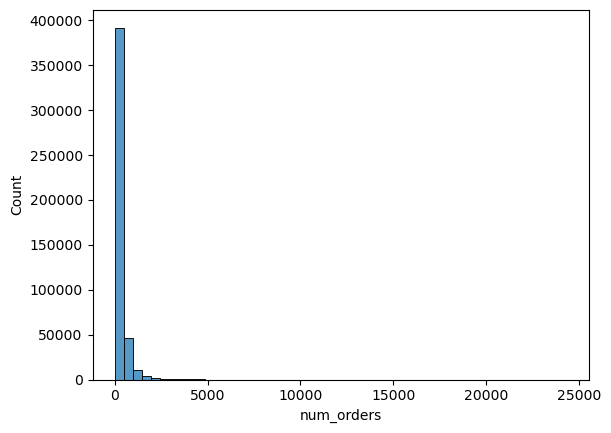

In [10]:
sns.histplot(train['num_orders'], bins=50, kde=False)

In [11]:
# The distribution of the number of orders (num_orders) is highly right-skewed.
#A large majority of the order quantities are concentrated between 0 and 1000.

In [12]:
category_avg = train.groupby('category')['num_orders'].mean().sort_values(ascending=False)
print(category_avg)


category
Rice Bowl       624.822288
Sandwich        529.776276
Salad           383.218460
Beverages       316.526116
Extras          293.834169
Pizza           222.817309
Other Snacks    162.234691
Starters        155.276110
Seafood         100.895898
Fish             85.595268
Soup             82.023353
Desert           66.250905
Pasta            59.137142
Biryani          30.651402
Name: num_orders, dtype: float64


In [13]:
#Rice Bowl, Sandwich, and Salad are the most frequently ordered and in-demand products. 
#Special attention should be paid to stock planning for these items.
#Biryani, Pasta, and Dessert are the least ordered products.

In [14]:
# A discount rate variable is added.
train["discount"] = (train["base_price"] - train["checkout_price"]) / train["base_price"]
test["discount"] = (test["base_price"] - test["checkout_price"]) / test["base_price"]

<Axes: xlabel='num_orders'>

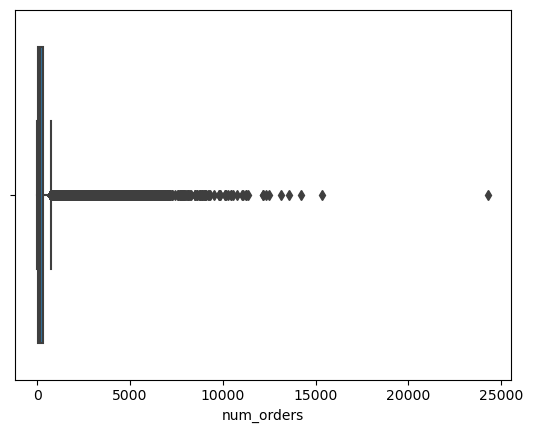

In [15]:
sns.boxplot(x=train['num_orders'])

In [16]:
#On the right side of the plot, there are many outliers ranging from 5,000 to 25,000.

<Axes: xlabel='checkout_price'>

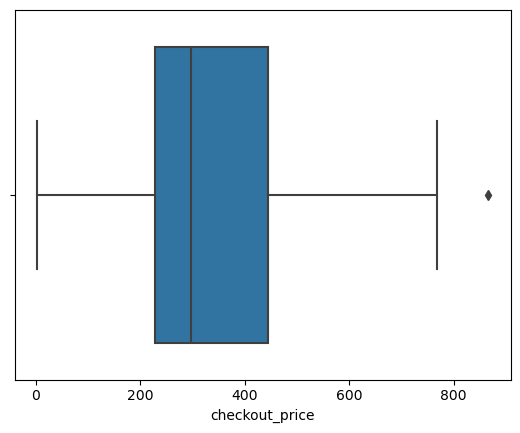

In [17]:
sns.boxplot(x=train['checkout_price'])

In [18]:
#The median price is around 350 units, and most prices are concentrated in the 200–600 range. A single point on the far right (approximately 850 units)
#represents a statistically outlying price.

In [19]:
# Fiyat farkı değişkeni ekliyoruz.

train["price_diff"] = train["base_price"] - train["checkout_price"]
test["price_diff"] = test["base_price"] - test["checkout_price"]

In [20]:
# Average number of orders by category
category_avg_map = train.groupby('category')['num_orders'].mean().to_dict()

train['category_avg_demand'] = train['category'].map(category_avg_map)
test['category_avg_demand'] = test['category'].map(category_avg_map)

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456548 entries, 0 to 456547
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     456548 non-null  int64  
 1   week                   456548 non-null  int64  
 2   center_id              456548 non-null  int64  
 3   meal_id                456548 non-null  int64  
 4   checkout_price         456548 non-null  float64
 5   base_price             456548 non-null  float64
 6   emailer_for_promotion  456548 non-null  int64  
 7   homepage_featured      456548 non-null  int64  
 8   num_orders             456548 non-null  int64  
 9   category               456548 non-null  object 
 10  cuisine                456548 non-null  object 
 11  city_code              456548 non-null  int64  
 12  region_code            456548 non-null  int64  
 13  center_type            456548 non-null  object 
 14  op_area                456548 non-nu

In [22]:
#LabelEncoding
cat_cols = ['category', 'cuisine', 'center_type']
le = LabelEncoder()

for col in cat_cols:
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])

In [23]:
features = [
    'week', 'center_id', 'meal_id',
    'checkout_price', 'base_price', 'price_diff', 'discount',
    'emailer_for_promotion', 'homepage_featured',
    'category', 'cuisine', 'center_type',
    'city_code', 'region_code', 'op_area',
    'category_avg_demand'
]


In [24]:
X_train = train[features]
y_train = train['num_orders']
X_test = test[features]


In [25]:

from sklearn.metrics import mean_squared_log_error

model = lgb.LGBMRegressor(
    objective='regression',
    n_estimators=1000,
    learning_rate=0.05,
    random_state=42
)

model.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1415
[LightGBM] [Info] Number of data points in the train set: 456548, number of used features: 16
[LightGBM] [Info] Start training from score 261.872760


LGBMRegressor(learning_rate=0.05, n_estimators=1000, objective='regression',
              random_state=42)

In [26]:
y_pred_raw = model.predict(X_train)
train['pred'] = y_pred_raw
train['is_negative'] = train['pred'] < 0

# Average discount in cases with negative predictions
print("Negatif tahminlerde ortalama discount:", train[train['is_negative']]['discount'].mean())
print("Genel ortalama discount:", train['discount'].mean())


Negatif tahminlerde ortalama discount: 0.046253147735369926
Genel ortalama discount: 0.057195002662159884


In [27]:
#We set negative predictions to zero for logarithmic calculations.
y_pred = np.clip(model.predict(X_train), a_min=0, a_max=None)

rmsle = np.sqrt(mean_squared_log_error(y_train, y_pred))
print("Train RMSLE:", rmsle)


Train RMSLE: 0.602196426006662


In [28]:
train_backup1 = train.copy()
test_backup1 = test.copy()


In [29]:
#New features

meal_avg = train_backup1.groupby('meal_id')['num_orders'].mean().to_dict()
train_backup1['meal_avg_demand'] = train_backup1['meal_id'].map(meal_avg)
test_backup1['meal_avg_demand'] = test_backup1['meal_id'].map(meal_avg)


In [30]:
# We add them to the features list
features.append('meal_avg_demand')
 

In [31]:
X_train = train_backup1[features]
y_train = train_backup1['num_orders']
X_test = test_backup1[features]


In [32]:
model = lgb.LGBMRegressor(
    objective='regression',
    n_estimators=1000,
    learning_rate=0.05,
    random_state=42
)

model.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1467
[LightGBM] [Info] Number of data points in the train set: 456548, number of used features: 17
[LightGBM] [Info] Start training from score 261.872760


LGBMRegressor(learning_rate=0.05, n_estimators=1000, objective='regression',
              random_state=42)

In [33]:
y_pred = np.clip(model.predict(X_train), a_min=0, a_max=None)
rmsle = np.sqrt(mean_squared_log_error(y_train, y_pred))
print("Train RMSLE:", rmsle)


Train RMSLE: 0.5613509888571802


In [34]:
# 2. Features

In [35]:
train_backup2 = train_backup1.copy()
test_backup2 = test_backup1.copy()


In [36]:
center_avg = train_backup2.groupby('center_id')['num_orders'].mean().to_dict()
train_backup2['center_avg_demand'] = train_backup2['center_id'].map(center_avg)
test_backup2['center_avg_demand'] = test_backup2['center_id'].map(center_avg)

features.append('center_avg_demand')


In [37]:
X_train = train_backup2[features]
y_train = train_backup2['num_orders']
X_test = test_backup2[features]

model = lgb.LGBMRegressor(
    objective='regression',
    n_estimators=1000,
    learning_rate=0.05,
    random_state=42
)

model.fit(X_train, y_train)


y_pred = np.clip(model.predict(X_train), a_min=0, a_max=None)
rmsle = np.sqrt(mean_squared_log_error(y_train, y_pred))
print("Train RMSLE:", rmsle)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1545
[LightGBM] [Info] Number of data points in the train set: 456548, number of used features: 18
[LightGBM] [Info] Start training from score 261.872760
Train RMSLE: 0.5478552304097779


In [38]:
# New features
train_backup3 = train_backup2.copy()
test_backup3 = test_backup2.copy()

In [39]:
type_avg = train_backup3.groupby('center_type')['num_orders'].mean().to_dict()
train_backup3['center_type_avg_demand'] = train_backup3['center_type'].map(type_avg)
test_backup3['center_type_avg_demand'] = test_backup3['center_type'].map(type_avg)

features.append('center_type_avg_demand')


In [40]:
X_train = train_backup3[features]
y_train = train_backup3['num_orders']
X_test = test_backup3[features]


model = lgb.LGBMRegressor(
    objective='regression',
    n_estimators=1000,
    learning_rate=0.05,
    random_state=42
)

model.fit(X_train, y_train)

y_pred = np.clip(model.predict(X_train), a_min=0, a_max=None)
rmsle = np.sqrt(mean_squared_log_error(y_train, y_pred))
print("Train RMSLE:", rmsle)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1549
[LightGBM] [Info] Number of data points in the train set: 456548, number of used features: 19
[LightGBM] [Info] Start training from score 261.872760
Train RMSLE: 0.5503548581291184


In [41]:
# Time effect as a lag feature
# We shift the order counts by one week to reflect the previous week's demand. For example, week 143's num_orders will be assigned to week 144.
# We will create a new column called prev_week_orders.
# This will only be applied to the training set, since the test set does not contain num_orders.
# We'll add the prev_week_orders column to the test set with a default value of 0.

In [42]:
train_backup4 = train_backup2.copy()
test_backup4 = test_backup2.copy()

In [43]:
train_lag = train_backup4[['center_id', 'meal_id', 'week', 'num_orders']].copy()
train_lag['week'] = train_lag['week'] + 1 
train_lag = train_lag.rename(columns={'num_orders': 'prev_week_orders'})

In [44]:
train_lag.head()

,center_id,meal_id,week,prev_week_orders
0,55,1885,2,177
1,55,1993,2,270
2,55,2539,2,189
3,55,2139,2,54
4,55,2631,2,40


In [45]:
train_lagged = train_backup4.merge(train_lag, on=['center_id', 'meal_id', 'week'], how='left')
features.append('prev_week_orders')

In [46]:
train_lagged.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,...,center_type,op_area,discount,price_diff,category_avg_demand,pred,is_negative,meal_avg_demand,center_avg_demand,prev_week_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177,0,...,2,2.0,0.101517,15.46,316.526116,256.594392,False,752.456365,163.475709,NaN
1,1466964,1,55,1993,136.83,135.83,0,0,270,0,...,2,2.0,-0.007362,-1.00,316.526116,227.990635,False,598.853544,163.475709,NaN
2,1346989,1,55,2539,134.86,135.86,0,0,189,0,...,2,2.0,0.007361,1.00,316.526116,75.908997,False,309.494594,163.475709,NaN
3,1338232,1,55,2139,339.50,437.53,0,0,54,0,...,2,2.0,0.224053,98.03,316.526116,-9.396882,True,42.813462,163.475709,NaN
4,1448490,1,55,2631,243.50,242.50,0,0,40,0,...,2,2.0,-0.004124,-1.00,316.526116,48.887324,False,104.239051,163.475709,NaN


In [47]:
train_lagged["prev_week_orders"].isnull().sum()

25101

In [48]:
#Let's fill the null values.
train_lagged['prev_week_orders'] = train_lagged['prev_week_orders'].fillna(0)

In [49]:
features.remove('center_type_avg_demand')

In [50]:
X_train = train_lagged[features]
y_train = train_lagged['num_orders']


In [51]:
for col in features:
    if col not in train_lagged.columns:
        print(f"❌ Eksik sütun: {col}")



In [52]:
model = lgb.LGBMRegressor(
    objective='regression',
    n_estimators=1000,
    learning_rate=0.05,
    random_state=42
)

model.fit(X_train, y_train)

y_pred = np.clip(model.predict(X_train), a_min=0, a_max=None)
rmsle = np.sqrt(mean_squared_log_error(y_train, y_pred))
print("Train RMSLE with Lag Feature:", rmsle)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1800
[LightGBM] [Info] Number of data points in the train set: 456548, number of used features: 19
[LightGBM] [Info] Start training from score 261.872760
Train RMSLE with Lag Feature: 0.5197626933699483


In [53]:
#We add the same column to the test data as well to avoid confusion.
test_backup4['prev_week_orders'] = 0  
X_test = test_backup4[features]       
test_backup4['num_orders'] = np.clip(model.predict(X_test), a_min=0, a_max=None)


In [54]:
train_backup5 = train_backup4.copy()
test_backup5 = test_backup4.copy()

In [55]:
#Historical average for each meal_id + center_id combination

combo_avg = train_backup5.groupby(['center_id', 'meal_id'])['num_orders'].mean().to_dict()
train_lagged['combo_avg_demand'] = train_lagged.set_index(['center_id', 'meal_id']).index.map(combo_avg)
test_backup5['combo_avg_demand'] = test_backup5.set_index(['center_id', 'meal_id']).index.map(combo_avg)
test_backup5['combo_avg_demand'] = test_backup5['combo_avg_demand'].fillna(0)

features.append('combo_avg_demand')

In [56]:
X_train = train_lagged[features]
y_train = train_lagged['num_orders']



model = lgb.LGBMRegressor(
    objective='regression',
    n_estimators=1000,
    learning_rate=0.05,
    random_state=42
)

model.fit(X_train, y_train)

y_pred = np.clip(model.predict(X_train), a_min=0, a_max=None)
rmsle = np.sqrt(mean_squared_log_error(y_train, y_pred))
print("Train RMSLE:", rmsle)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2055
[LightGBM] [Info] Number of data points in the train set: 456548, number of used features: 20
[LightGBM] [Info] Start training from score 261.872760
Train RMSLE: 0.4859715016369261


In [57]:
X_test = test_backup5[features]
test_backup5['num_orders'] = np.clip(model.predict(X_test), a_min=0, a_max=None)


In [58]:
submission = test_backup5[['id', 'num_orders']]
submission.to_csv("submission.csv", index=False)



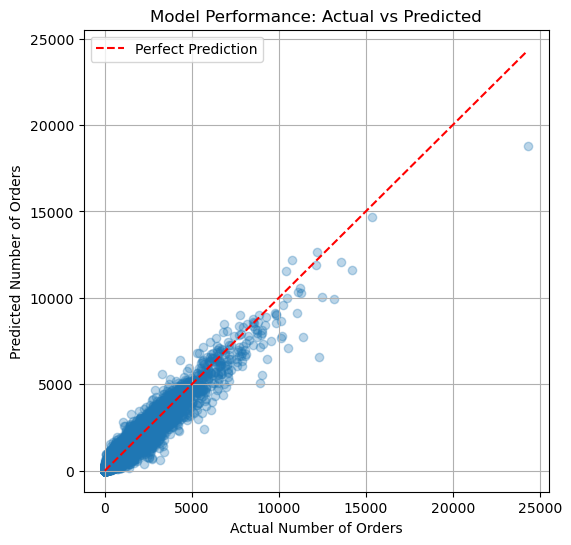

In [59]:
plt.figure(figsize=(6,6))
plt.scatter(y_train, y_pred, alpha=0.3)
plt.plot([0, max(y_train)], [0, max(y_train)], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Number of Orders')
plt.ylabel('Predicted Number of Orders')
plt.title('Model Performance: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()


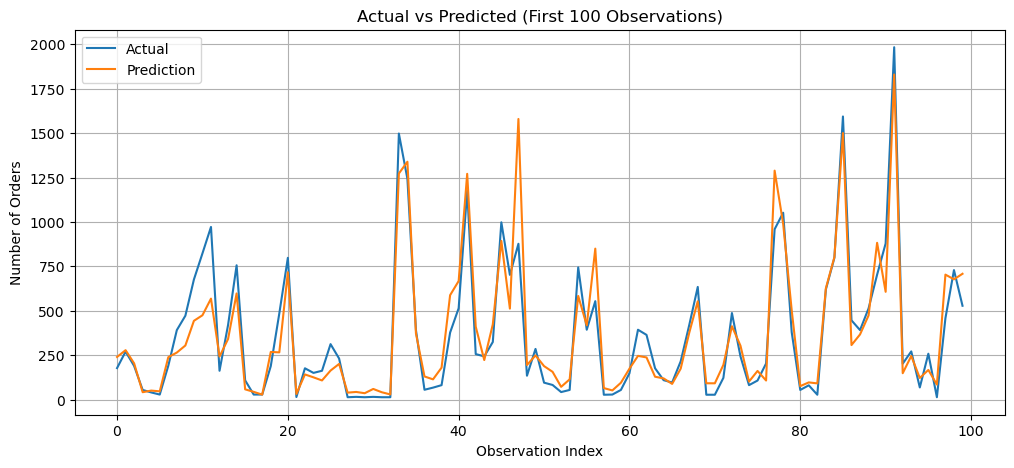

In [60]:
#Sample comparison for the first 100 rows
compare_df = pd.DataFrame({'Actual': y_train[:100].values, 'Prediction': y_pred[:100]})
compare_df.reset_index(drop=True).plot(figsize=(12, 5))
plt.title("Actual vs Predicted (First 100 Observations)")
plt.xlabel("Observation Index")
plt.ylabel("Number of Orders")
plt.grid(True)
plt.show()

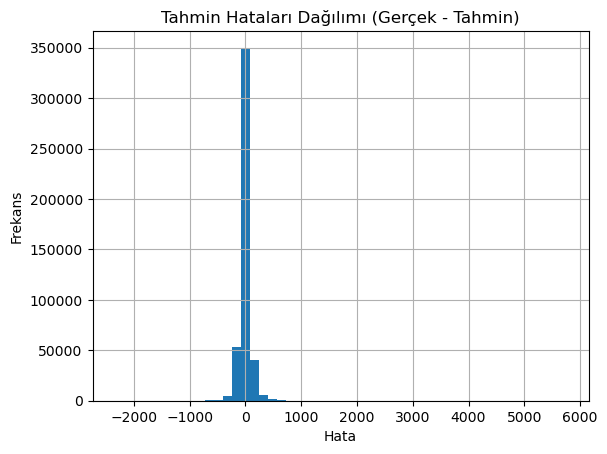

In [61]:
hatalar = y_train - y_pred
plt.hist(hatalar, bins=50)
plt.title("Tahmin Hataları Dağılımı (Gerçek - Tahmin)")
plt.xlabel("Hata")
plt.ylabel("Frekans")
plt.grid(True)
plt.show()


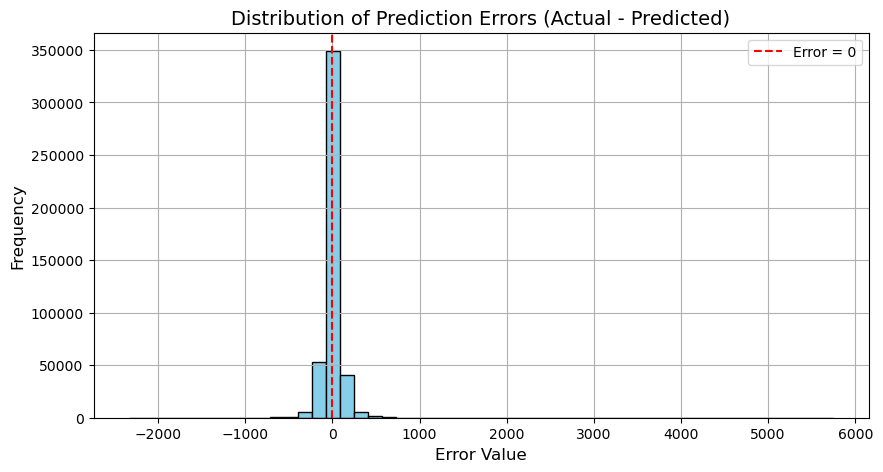

In [62]:
# Error
errors = y_train - y_pred

# Histogram
plt.figure(figsize=(10,5))
plt.hist(errors, bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Prediction Errors (Actual - Predicted)", fontsize=14)
plt.xlabel("Error Value", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.axvline(0, color='red', linestyle='--', label='Error = 0')
plt.legend()
plt.grid(True)
plt.show()


##  Model Performance Summary

Throughout the iterations, different feature engineering strategies were tested to improve model accuracy. The evaluation metric used was **RMSLE (Root Mean Squared Log Error)**, which is well-suited for skewed demand data.

| Model Version                | Train RMSLE |
|-----------------------------|-------------|
| Initial model               | 0.5504      |
| With Lag Feature            | 0.5198      |
| Further Feature Enhancements | 0.4860      |

  As seen above, incorporating lag-based temporal features and refining the feature set significantly reduced the RMSLE score, indicating better fit and prediction capability on training data.

